In [3]:
import pandas as pd

post = pd.read_csv('Assignment 3 Edmunds Posts.csv')

In [260]:
bmw = {'bmw3':'3series','bmw5':'5series','bmw7':'7series',
       'bmw 3':'3series','bmw 5':'5series','bmw 7':'7series','3 series':'3series','5 series':'5series','7 series':'7series'}

rep_dic = {'sc':'sclass','lexusls':'ls','lexuses':'es','mb':'mercedes','benz':'mercedes',"n't":'not'}

def repl(w,car_type_list):
    l = []
    for ww in w:
        if ww in car_brand.keys() and len(set(car_brand[ww]).intersection(car_type_list))==1:
            l.append(list(set(car_brand[ww]).intersection(car_type_list))[0])
        else:
            l.append(ww)
    return l

def repl2(w):
    l=[]
    for ww in w:
        if ww in rep_dic.keys():
                l.append(rep_dic[ww])
        else:
                l.append(ww)
    return l

def multi_replace(text, dictionary):
    for i, j in dictionary.iteritems():
        text = text.replace(i, j)
    return text

In [275]:
from textblob import TextBlob
import re
import string

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
wnl = WordNetLemmatizer()


car_type = ['es','ls','rx','a8','a6','3series','5series','7series','xj','sclass']
car_brand={'audi':['a6','a8'],'bmw':['3series','5series','7series'],'jaguar':'xj','lexus':['es','ls','rx'],'mercedes':'sclass'}
total_score = []

for review in post['Posts']:
    score = []
    words_lem = []
    review = multi_replace(review,bmw)
    review = re.sub('-','',review)
    review = nltk.word_tokenize(review.lower())
    review_words = [word for word in review if word not in set(string.punctuation)]
    filtered_words_sw = [word for word in review_words if word not in stopwords.words('english')]
    filtered_words_sw = repl2(filtered_words_sw)
    car_type_list=[]
    for u in filtered_words_sw:
        if u in car_type:
            car_type_list.append(u)
    filtered_words_sw =  repl(filtered_words_sw,car_type_list)
    filtered_poi = nltk.pos_tag(filtered_words_sw)
    wordnet_tag ={'NN':'n','JJ':'a','VB':'v','RB':'r'}
    for t in filtered_poi:
        try: words_lem.append(wnl.lemmatize(t[0],wordnet_tag[t[1][:2]]))
        except: words_lem.append(wnl.lemmatize(t[0]))
    
    for m in car_type:
        if m in words_lem:
                m_indices = [i for i, x in enumerate(words_lem) if x == m]
                m_senti = 0
                for num in m_indices:
                    if num <len(words_lem)-5:
                        m_string = ' '.join(words_lem[num-5:num+5])
                        m_senti += TextBlob(m_string).sentiment.polarity
                    else:
                        m_string = ' '.join(words_lem[num-5:])
                        m_senti += TextBlob(m_string).sentiment.polarity
                senti=m_senti
        else:
            senti = 0
        score.append(senti)
    
    total_score.append(score)

In [278]:
score_diff = score_df.copy()
for i in range(len(score_df.columns)):
    for ii in range(i+1,len(score_df.columns)):
            temp = score_df.columns[i] +'_'+score_df.columns[ii]
            score_diff[temp]=score_df[score_df.columns[i]]-score_df[score_df.columns[ii]]

In [279]:
use_new = []
for q in score_diff.columns[10:]:
    p1,p2 = re.split('_',q)
    neg = (score_diff[q]<0)
    neg_sent  = score_diff[q][neg].sum()/score_diff[q][neg].count()
    pos = (score_diff[q]>0)
    pos_sent  = score_diff[q][pos].sum()/score_diff[q][pos].count()
    use_new.append((p1,p2,pos_sent,neg_sent))

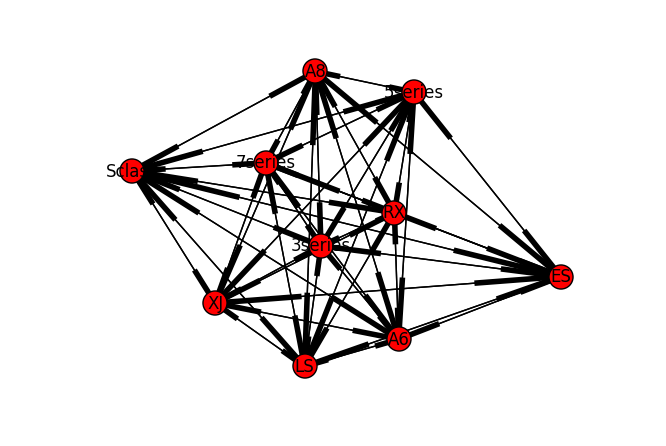

In [280]:
import matplotlib.pyplot as plt
%matplotlib inline

import networkx as nx
G = nx.DiGraph()

G.add_nodes_from(score_df.columns)

for a,b,pos,neg in use_new:
    if pos!=0 :
        G.add_edge(b,a,{'weight':pos})
    if neg!=0:
        G.add_edge(a,b,{'weight':abs(neg)})
        
plt.figure()
nx.draw(G, with_labels=True)
plt.show()

In [281]:
pr_new = nx.pagerank(G, alpha=1,weight='weight')
pr_new_df = pd.DataFrame.from_dict(pr_new,orient='index')
pr_new_df = pr_new_df.reset_index()
pr_new_df.columns=['Model','pr']
cs_new = pd.read_csv('/Users/leeanthea/Desktop/car_sales.csv')
cs_new = cs_new.merge(pr_new_df)

In [282]:
cs_new[['Sales','pr']].corr(method='pearson', min_periods=1)

,Sales,pr
Sales,1.000000,0.611037
pr,0.611037,1.000000


In [283]:
cs_new[['Sales','pr']].corr(method='spearman', min_periods=1)

,Sales,pr
Sales,1.000000,0.624242
pr,0.624242,1.000000
